In [ ]:
from PIL import Image
from pathlib import Path
from cell_paint_seg import utils
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from skimage import exposure
import numpy as np
from skimage import measure
from tqdm import tqdm

In [ ]:
# List of channel names ordered by channel number
channels = ["Brightfield", "ER", "AGP", "Mito", "DNA", "RNA"]

# Directories where images and predicted segmentations are located
path_dir_im = "/imagestore/Aneesh/Assay Dev 20230329/BR00142687__2024-03-29T18_18_57-Measurement 1/Images"
path_dir_seg_ilastik = "/imagestore/Tommy/ilastik cp comparison/segmentations/"

reg_stat_limits = {"area": (-1, 4000)}


# Substrings that identify whether a file should be collected
tag_im = ".tiff"
tag_seg_ilastik = ".tif"

In [ ]:
id_to_path_im, sftp_im = utils.get_id_to_path(path_dir_im, tag=tag_im, remote=True)
id_to_path_seg_ilastik, sftp_seg = utils.get_id_to_path(path_dir_seg_ilastik, tag=tag_seg_ilastik, remote=True)

for n_id, id in enumerate(id_to_path_seg_ilastik.keys()):
    print(id)
    images = utils.read_ims(id_to_path_im[id], sftp_client=sftp_im)

    seg_pred_ilastik = utils.read_seg(id_to_path_seg_ilastik[id], sftp_client=sftp_seg)
    regions = utils.reg_prop_filter(measure.regionprops(seg_pred_ilastik), reg_stat_limits)
    seg_pred_ilastik_filtered = np.zeros_like(seg_pred_ilastik)
    for region in regions:
        seg_pred_ilastik_filtered[seg_pred_ilastik == region.label] = region.label

    image_dna = images[-2] #[channels.index("DNA")]
    image_dna = exposure.equalize_adapthist(image_dna, clip_limit=0.03)
    image_rna = images[-1] #[channels.index("RNA")]
    image_rna = exposure.equalize_adapthist(image_rna, clip_limit=0.03)

    f, axs = plt.subplots(nrows=2, ncols=2)
    for ax_col, seg in zip(axs.T, [np.zeros_like(image_dna), seg_pred_ilastik_filtered]):
        seg_masked = np.ma.masked_array(seg, mask=seg == 0)

        ax_col[0].imshow(image_dna, cmap="gray")
        ax_col[0].imshow(seg_masked % 20, cmap="tab20", alpha=0.7)
        ax_col[0].axis("off")

        ax_col[1].imshow(image_rna, cmap="gray")
        ax_col[1].imshow(seg_masked % 20, cmap="tab20", alpha=0.7)
        ax_col[1].axis("off")

    for ax_col, name in zip(axs, ["DNA?", "CellProfiler", "ilastik", "CellPose"]):
        ax_col[0].set_title(name)

    axs[1,0].set_title("RNA?")
    f.set_size_inches(16, 8)
    f.tight_layout()
    plt.show()

    if n_id > 5:
        break

  0%|          | 6/3456 [00:07<1:13:32,  1.28s/it]


<Axes: xlabel='Area', ylabel='Eccentricity'>

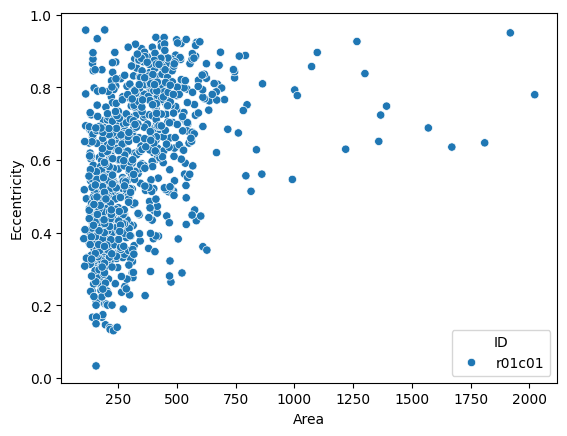

In [25]:
id_to_path_im, sftp_im = utils.get_id_to_path(path_dir_im, tag=tag_im, remote=True)
id_to_path_seg_ilastik, sftp_seg = utils.get_id_to_path(path_dir_seg_ilastik, tag=tag_seg_ilastik, remote=True)

data_area = []
data_ecc = []
data_mn_int = []
data_id = []


for n_id, id in enumerate(tqdm(id_to_path_seg_ilastik.keys())):
    images = utils.read_ims(id_to_path_im[id], sftp_client=sftp_im)
    image_stacked = np.stack(images, axis=2)

    seg_pred_ilastik = utils.read_seg(id_to_path_seg_ilastik[id], sftp_client=sftp_seg)
    regions = utils.reg_prop_filter(measure.regionprops(seg_pred_ilastik, intensity_image = image_stacked), reg_stat_limits)
    for region in regions:
        data_area.append(region.area)
        data_ecc.append(region.eccentricity)
        data_mn_int.append(region.intensity_mean)
        data_id.append(id[:-6])

    if n_id > 5:
        break

data = {"Eccentricity" : data_ecc, "Area": data_area, "ID" : data_id}
df = pd.DataFrame(data)

sns.scatterplot(df, x="Area", y="Eccentricity", hue="ID")

In [26]:
data_mn_int

[array([ 816.95518499, 3819.63887441]),
 array([ 1339.53310105, 10923.11149826]),
 array([ 1143.16909621, 10496.44314869]),
 array([ 1394.07283465, 10897.16141732]),
 array([ 1303.92361111, 10572.61111111]),
 array([ 1357.79076923, 11957.88      ]),
 array([1179.86842105, 6431.53508772]),
 array([1435.07142857, 7172.21428571]),
 array([ 1183.07894737, 10536.7481203 ]),
 array([ 1261.95608108, 12459.01689189]),
 array([1403.03355705, 6686.38926174]),
 array([1188.13816926, 8047.70466321]),
 array([1171.80722892, 8820.75387263]),
 array([ 1784.85678392, 15144.03768844]),
 array([ 1745.02736318, 13757.99253731]),
 array([ 1872.22222222, 12049.5380117 ]),
 array([1419.83333333, 7867.35632184]),
 array([ 1164.97377049, 12868.07213115]),
 array([ 1207.51428571, 10740.93333333]),
 array([1924.81290323, 9095.94516129]),
 array([ 1707.31151242, 11403.10158014]),
 array([ 1636.03892944, 12248.8053528 ]),
 array([ 1587.52554745, 12632.33333333]),
 array([ 1222.088     , 13610.78133333]),
 array([